# Imports

In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, exp, Expression
from biogeme.models import loglogit
from biogeme.tools import likelihood_ratio_test
from biogeme.results import compile_estimation_results
from biogeme.models import loglogit,  boxcox
from biogeme.models.piecewise import piecewise_formula
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.biogeme import BIOGEME

import pickle

import numpy as np
import os

from scipy.stats import chi2

# Data & Variables

In [2]:
# Define the relative path to the data folder
file_path = os.path.join(os.pardir, 'lpmc01.dat')

#file_path = os.path.join(data_folder, 'lpmc01.dat')

df = pd.read_csv(file_path, sep = '\t')
df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['age_scaled'] = df['age'] / df['age'].max()
df['cost_driving'] = df['cost_driving_ccharge'] + df['cost_driving_fuel']
df['dur_pt'] = df['dur_pt_access'] + df['dur_pt_rail'] + df['dur_pt_int'] + df['dur_pt_bus']

# max_cost = df['cost_driving'].max() if df['cost_driving'].max() > df['cost_transit'].max() else df['cost_transit'].max()
# df['cost_driving'] = df['cost_driving']/max_cost
# df['cost_transit'] = df['cost_transit']/max_cost


database1 = db.Database('lpmc01', df)


# Define the given veriables 
dur_pt = Variable('dur_pt')
cost_driving = Variable('cost_driving')
age_scaled = Variable('age_scaled')
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')



# Define transport availability
# Assume pt, walking, cycle always available, with car availability depending on number of cars per household. From the data, 
# people without driving licenses choose driving as their mode of transport (eg. row 28). 
av_drive =  (car_ownership > 0)
av_pt =1
av_walk = 1
av_cycle = 1

variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")



# Define pt_cost (not needed)
# Original paper, page 31: "Public transport fares are determined for single trips using Oystercard/contactless payment."
# Therefore, cost_transit should already consider faretype and bus_scale

database = db.Database('lpmc01', df)
variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")

# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.
'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.


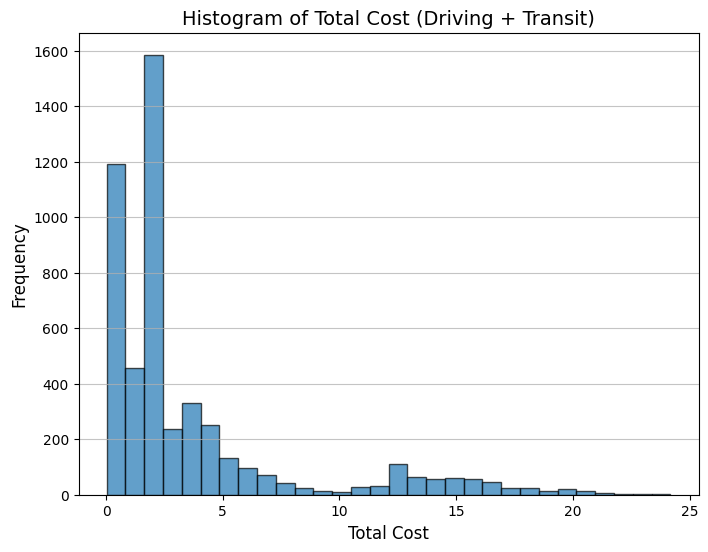

In [3]:
import matplotlib.pyplot as plt
cost = df["cost_driving"] + df["cost_transit"]
plt.figure(figsize=(8, 6))
plt.hist(cost, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Total Cost (Driving + Transit)', fontsize=14)
plt.xlabel('Total Cost', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

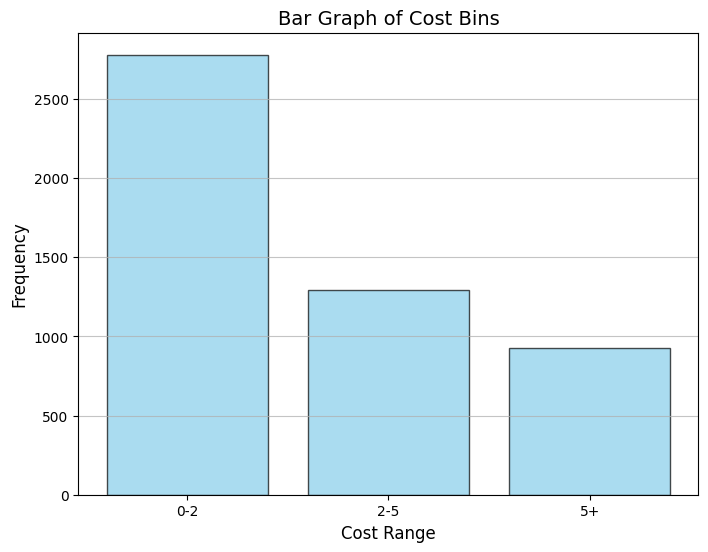

In [4]:
bins = [0, 2, 5, cost.max()]
labels = ['0-2', '2-5', '5+']

# Categorizing the data into bins
cost_bins = pd.cut(cost, bins=bins, labels=labels, include_lowest=True)

# Counting the frequency in each bin
bin_counts = cost_bins.value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(bin_counts.index, bin_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Bar Graph of Cost Bins', fontsize=14)
plt.xlabel('Cost Range', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Model Definition

In [5]:
# Assume every mode of transport is available
availability_walk = 1  
availability_cycle = 1  
availability_pt = 1     
availability_drive = 1

availability = {
    1: availability_walk,   # Walking
    2: availability_cycle,  # Cycling
    3: availability_pt,     # Public Transport
    4: availability_drive   # Driving
}

# Define alternative-specific parameters for travel time
B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
B_COST = Beta('B_COST', 0, None, None, 0)

G_TIME_WALK_AGE = Beta('G_TIME_WALK_AGE', 0, None, None, 0)
G_TIME_CYCLE_AGE = Beta('G_TIME_CYCLE_AGE', 0, None, None, 0) 
G_TIME_PT_AGE = Beta('G_TIME_PT_AGE', 0, None, None, 0)
G_TIME_DRIVE_AGE = Beta('G_TIME_DRIVE_AGE', 0, None, None, 0) 

## Piecewise Linear

In [6]:
thresholds = [0, 1, 5, None]

ALPHA_0_1 = Beta('ALPHA_0_1', 0, None, None, 0)
ALPHA_1_5 = Beta('ALPHA_1_5', 0, None, None, 0)
ALPHA_5_INF = Beta('ALPHA_5_INF', 0, None, None, 0)
betas_piecewise = [ALPHA_0_1, 
                   ALPHA_1_5, 
                   ALPHA_5_INF]

piecewise_cost_driving = piecewise_formula(
    'cost_driving', thresholds, betas_piecewise
)

piecewise_cost_pt = piecewise_formula(
    'cost_transit', thresholds, betas_piecewise
)


In [7]:
# Utility functions with interaction terms
V_WALK = (B_TIME_WALK + G_TIME_WALK_AGE * age_scaled) * dur_walking
V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + G_TIME_CYCLE_AGE* age_scaled) * dur_cycling
#V_PT = ASC_PT + B_COST*piecewise_cost_pt + (B_TIME_PT + G_TIME_PT_AGE* age_scaled) * dur_pt
#V_DRIVE = ASC_DRIVE +  B_COST*piecewise_cost_driving + (B_TIME_DRIVE + G_TIME_DRIVE_AGE * age_scaled) * dur_driving
V_PT = ASC_PT + piecewise_cost_pt + (B_TIME_PT + G_TIME_PT_AGE* age_scaled) * dur_pt
V_DRIVE = ASC_DRIVE +  piecewise_cost_driving + (B_TIME_DRIVE + G_TIME_DRIVE_AGE * age_scaled) * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_piecewise = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [8]:
biogeme_piecewise = bio.BIOGEME(database, model_3_piecewise)
biogeme_piecewise.modelName = 'model_3_piecewise'

results_m3_piecewise = biogeme_piecewise.estimate()

print("Estimation results for Model 3 piecewise:")
print(results_m3_piecewise.get_estimated_parameters())

Estimation results for Model 3 piecewise:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ALPHA_0_1        -0.694669      0.084508    -8.220165  2.220446e-16
ALPHA_1_5        -0.040249      0.052875    -0.761206  4.465342e-01
ALPHA_5_INF      -0.203265      0.038237    -5.315889  1.061379e-07
ASC_CYCLE        -4.720183      0.208686   -22.618594  0.000000e+00
ASC_DRIVE        -2.102498      0.150318   -13.986984  0.000000e+00
ASC_PT           -2.431676      0.153179   -15.874779  0.000000e+00
B_TIME_CYCLE     -5.030458      0.901862    -5.577855  2.435020e-08
B_TIME_DRIVE     -5.882143      0.882375    -6.666265  2.623946e-11
B_TIME_PT        -2.621283      0.487938    -5.372167  7.779602e-08
B_TIME_WALK      -7.762626      0.514986   -15.073481  0.000000e+00
G_TIME_CYCLE_AGE -4.508194      1.976506    -2.280891  2.255490e-02
G_TIME_DRIVE_AGE -1.666716      2.024651    -0.823211  4.103878e-01
G_TIME_PT_AGE    -3.081030      1.110146    -2.775338  5.514443e-03
G_TIME

In [9]:
print(results_m3_piecewise.print_general_statistics())

Number of estimated parameters:	14
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4173.734
Likelihood ratio test for the init. model:	5515.476
Rho-square for the init. model:	0.398
Rho-square-bar for the init. model:	0.396
Akaike Information Criterion:	8375.468
Bayesian Information Criterion:	8466.709
Final gradient norm:	1.5480E-02
Nbr of threads:	16



### Test Against Model 2

In [10]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [11]:
loglikehood_m3_piecewise = results_m3_piecewise.data.logLike
num_params_m3_piecewise = results_m3_piecewise.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam
 
# Calculate the LR statistic
LR = 2 * (loglikehood_m3_piecewise - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_piecewise - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 piecewise is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 piecewise over Model 2.")

Likelihood Ratio: 40.04237032660785
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
Model 3 piecewise is significantly better than Model 2.


In [12]:
alpha = 0.05
lr_test = likelihood_ratio_test(
    [loglikehood_m3_piecewise, num_params_m3_piecewise],
    [loglikehood_m2, num_params_m2],
    alpha  # Significance level of alpha
)
print(f" {lr_test[0]}")  

 H0 can be rejected at level 5.0%
